# Gaussian Mixture Model (GMM) and Expectation Maximization (EM) Algorithm

**Author**: James Chen, School of Animal Sciences, Virginia Tech

**Date**: Aug 3, 2022

Gaussian mixture model (GMM) is another approach to cluster a given dataset. Unlike K-means clustering algorithm, which has no assumption on the cluster distribution, GMM assumes each cluster following a multivariate normal (MVN) distribution. This approach is useful when the observed data shows different variation among the studied dimensions (variates). Ones can implement GMM by Expectation Maximization (EM) algorithm that leverages Bayesian Theorm to maximize the posterior probability. The posterior probability in GMM is the chance the observed data is sampled from the estiamted MVN distributions.

In this section, we will walk through each step of EM algorithm, and we will then compare the results generated from K-Means and GMM clustering approaches.

## **Data**
Similar to the previous note, we will simulate a dataset to help us understand the algorihtm.
We assume that there are `100` data points sampled from `2` different multivariate normal distributions.

In [2]:
# use a exclamation mark, "!", to call Shell command in Python
# !git clone https://github.com/vt-ads/intro_to_phenomics

In [3]:
import os
# change WD
os.chdir("/content/intro_to_phenomics")
# print WD
print("Current folder: ", os.getcwd())

Current folder:  /content/intro_to_phenomics


Shape:  (100, 2)
The first 10 data points: 
 [[40.07239537 45.6162229 ]
 [47.36525032 46.96804659]
 [50.96514022 26.62505176]
 [44.70544258 42.84493516]
 [28.88753861 47.5965643 ]
 [47.92173874 45.99756517]
 [38.94567599 43.20109208]
 [37.52149589 44.96302069]
 [54.05514095 32.39361961]
 [38.96804294 34.87011673]]


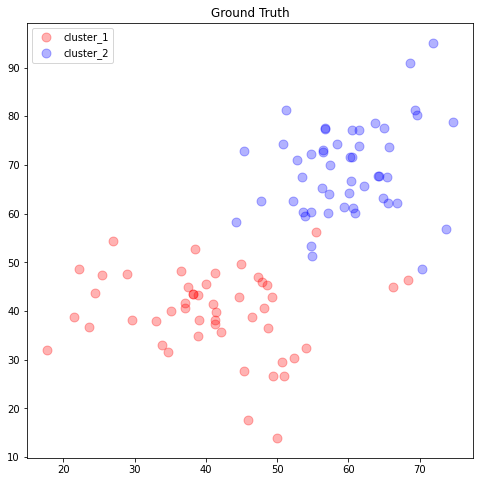

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# set random seed
np.random.seed(24061)

# number of clusters
k = 2
# number of data points in each cluster
n = 50
# total number of data points
N = n * k
# cluster proerties: means and standard deviation
means = [[40, 40], [60, 70]]
stds  = [[[80, 0],
          [0, 70]],
         [[60, 10],
          [10, 90]]]

# use np.random.multivariate_normal() to sample the datasets
data = []
for mean, std in zip(means, stds):
    data += [np.random.multivariate_normal(mean=mean, cov=std, size=n)]
data = np.concatenate(data)

# validattion ------------------------------
print("Shape: ", data.shape)
print("The first 10 data points: \n", data[:10])
# plotting
param_pts = dict(s=80, alpha=.3)
plt.figure(figsize=(8, 8))
plt.scatter(data[:n, 0], data[:n, 1], c="red",  label="cluster_1", **param_pts)
plt.scatter(data[n:, 0], data[n:, 1], c="blue", label="cluster_2", **param_pts)
plt.title("Ground Truth")
plt.legend()

## **Bayesian Theorm**
First, let's recap what Bayesian theorm is about:
$$
    P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}
    \tag{1}
$$

The theorm tells us, with the prior $P(A)$ and the conditional probability $P(B \mid A)$, we can estimate the posterior probability $P(A \mid B)$.

## **Prior**
So what is the prior? In our case, the prior is how many data points are sampled from the distribution $c_j$.
It can be expressed as:

$$
    \begin{split}
        P(A) &= P(c_{j}) = P(\mu_{j}, \Sigma_{j})  =\pi_{j}\\
    \end{split}
    \tag{2}
$$

where $\mu_j$ and $\Sigma_j$ are the mean and (co)variance of the distribution $c_j$, respectively.


In [12]:
# parameters
N = 100
k = 2

# randomly assign clusters (labels)
# use "quotients" as the initial labels
labels = np.random.random(N) // (1 / k)
pi     = [np.mean(labels == i) for i in range(k)]
print("labels:\n", labels)
print("\n")
print("pi:\n", pi)
print("\n")

# subset data by each cluster
ls_subdata = [data[labels == i]        for i       in range(k)]
ls_mu      = [np.mean(subdata, axis=0) for subdata in ls_subdata]
ls_sigma   = [np.cov(subdata.T)        for subdata in ls_subdata]
for i in range(2):
    print("mu_%d:\n"    % (i + 1), ls_mu[i])
    print("sigma_%d:\n" % (i + 1), ls_sigma[i])
    print("\n")

labels:
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 1.]


pi:
 [0.58, 0.42]


mu_1:
 [51.83485735 55.53160154]
sigma_1:
 [[177.26026291 136.84842508]
 [136.84842508 304.94241745]]


mu_2:
 [48.19518871 52.6958585 ]
sigma_2:
 [[157.28952364 146.14175736]
 [146.14175736 281.25526263]]




## **Probability density function**
Then, we can define $P(B)$ and $P(B \mid A)$ in the EM algorithm.
$P(B)$ describes how likely the sample $x_i$ is observed.
To calculate $P(B)$, we have to consider all the possible distributions:

$$
    \begin{split}
        P(B) &= P(x_{i}) = {\sum \limits_{j=1}^{k} P(x_{i} \mid c_{j}) P(c_{j})} \\
    \end{split}
    \tag{3}
$$

where $k$ is the total nubmer of possible distributions (i.e., clusters).

Finally, we need to calculate $P(B \mid A)$ to know $P(B)$.
$P(B \mid A)$ describes that how typical the data $x_i$ is sampled from the distribution $c_j$. This can be calculated by the probability density function (PDF) of a multivariate distribution:

$$
    \begin{split}
        P(B \mid A) &= P(x_{i} \mid c_{j}) \\
                    &= P(x_{i} \mid \mu_{j}, \Sigma_{j}) \\
                    &= \frac{1}{\sqrt{det(2\pi\Sigma_{j}^2)}} \exp({-\frac{1}{2}(x_{i}-\mu_{j})^T\Sigma_{j}^{-1}(x_{i}-\mu_{j})})
    \end{split}
    \tag{4}
$$


### Exercise 1
Define the PDF of a multivariate normal distribution. You will need:
* `np.matmul()`: matrix multiplication
* `np.exp()`:  get the exponential of an input array
* `np.linalg.inv()`: get the inverse of a matrix
* `np.linalg.det()`: get the determinant of an array


In [8]:
def pdf_mvn(x, mu, sigma):
    """ Compute the probability P(x | MVN(mu, sigma))

    Parameters
    ----------
    x : array_like
        the inspected data.
        A NumPy array in a shape of (p,), where p is the number of data dimension.
    mu : array_like
        the mean of the mvn distribution.
        A NumPy array in a shape of (p,), where p is the number of data dimension.
    sigma : array_like
        the standard deviation of the mvn distribution.
        A NumPy array in a shape of (p,), where p is the number of data dimension.

    Returns
    -------
    a floating number
        P(x | MVN(mu, sigma))

    Examples
    ---------
    x  = [10, 20]
    mu = [10, 20]
    sigma = [[10, 5],
             [5, 25]]
    pdf_mvn(x, mu, sigma) # should return 0.010610
    """
    sigma = np.array(sigma)
    mu = np.array(mu)
    x = np.array(x)

    d = np.linalg.det((sigma ** 2) * (2 * np.pi))
    #e = (-1/2) * np.matmul(np.matmul(np.transpose(x - mu), np.linalg.inv(sigma)), (x - mu))
    
    num1 = np.matmul((x - mu).T, np.linalg.inv(sigma))
    num2 = np.matmul(num1, (x - mu))
    num3 = np.exp(-0.5 * num2)

    sol = num3 / np.sqrt(d)

    return sol


# Validation -------
x = [10, 20]
mu = [10, 20]
sigma = [[10, 5],
        [5, 25]]

pdf_mvn(x, mu, sigma) # 0.010610

0.0006398269451711311

In [17]:
from modules.gmm import pdf_mvn

x = [10, 20]
mu = [10, 20]
sigma = [[10, 5],
        [5, 25]]

sigma = np.array(sigma)
mu = np.array(mu)
x = np.array(x)

pdf_mvn(x, mu, sigma) # 0.010610

0.01061032953945969

## **Expectation Stage (E Stage)**
Now, based on the Bayesian theorm, we have everything we need to calculate the posterior probability

$$
    \begin{split}
        P(A \mid B)
            &= \frac{P(B \mid A)P(A)}{P(B)} \\ \\
            &= P(c_{j} \mid x_{i}) \\ \\
            &= \frac{P(x_{i} \mid c_{j})P(c_{j})}{{\sum \limits_{j=1}^{k} P(x_{i} \mid c_{j}) P(c_{j})}} = r_{ij}
    \end{split}
    \tag{5}
$$

### Exercise 2
Complete the function `calculate_R(X, pi, mu, sigma)`. You need to create a nested loop, and use the pre-defined function `pdf_mvn(X, mu, sigma)`.

In [20]:
def calculate_R(X, pi, mu, sigma):
    """Calculate posterior probability, P(xi|cj)

    Parameters
    ----------
    X : array_like
        A NumPy array with a shape of (n, p),
        where n is the number of observations,
        and p is the data dimension.
    pi : array_like
        A NumPy array with a shape of (k,).
        Prior, P(A).
    mu : array_like
        A Numpy array with a shape of (k, p)
        The mean of the inspected MVN distribution
    sigma : array_like
        A Numpy array with a shape of (k, p, p)
        The covariance of the inspected MVN distribution

    Returns
    -------
    array_like, a NumPy array with a shape of (n, k),
    where n is the number of observations,
    and k is the number of clusters.
    """
    # create an empty R matrix
    n, k = len(X), len(mu)
    R = np.zeros((n, k))
    # numerator
    for i in range(n):
      for j in range(k):
        R[i, j] = pdf_mvn(X[i], mu[j], sigma[j]) * pi[j]
    # denominator
    R /= np.sum(R, axis=1)[:, None]  # allow you to multiple matrices of different dimensions
    return R

# Validation ---
R = calculate_R(data, pi,ls_mu, ls_sigma)
print(R[:10, ])
print(R.shape)


[[0.4810322  0.5189678 ]
 [0.5175696  0.4824304 ]
 [0.72069246 0.27930754]
 [0.5054058  0.4945942 ]
 [0.53294212 0.46705788]
 [0.52472135 0.47527865]
 [0.47440837 0.52559163]
 [0.47644278 0.52355722]
 [0.71703087 0.28296913]
 [0.47870708 0.52129292]]
(100, 2)


## **Maximization Stage (M Stage)**
In the M stage, we need to update the hypothesis $\theta$ to maximize the likelihood, $\ell(\theta)$. The hypothesis includes the prior $P(c_j)$, the mean $\mu_j$, and the coariance $\Sigma_j$ for the distribution $j$. To do this, we can use the posterior probability $r_{ij}$ to assign weight to each observation.

$$
    \begin{split}
        P(c_{j})&= \frac{\sum \limits_{i=1}^{n} r_{ij}}
                                   {\sum \limits_{j=1}^{k}\sum \limits_{i=1}^{n} r_{ij}}\\\\
        \mu_{j} &= \frac{\sum \limits_{i=1}^{n} r_{ij}x_i}
                        {\sum \limits_{i=1}^{n} r_{ij}}\\\\
        \Sigma_{j} &= \frac{\sum \limits_{i=1}^{n} r_{ij}(x_i - \mu_j)^T(x_i - \mu_j)}
                           {\sum \limits_{i=1}^{n} r_{ij}}\\
    \end{split}
$$

In [21]:
def update_pi(R):
    return R.mean(axis=0)

def update_mu(R, X):
    n, k = R.shape
    new_mu = [0] * k
    for j in range(k):
        num = np.sum(X * R[:, j][:, None], axis=0)
        den = np.sum(R[:, j])
        new_mu[j] = num / den
    return new_mu

def update_sigma(R, X, mu):
    n, k = R.shape
    new_sigma = [0] * k
    for j in range(k):
        # weighted mean squared devication
        weighted_MSD = [np.matmul((x - mu[j])[:, None], (x - mu[j])[:, None].T) * r for x, r in zip(X, R[:, j])]
        new_sigma[j] = np.sum(weighted_MSD, axis=0) / np.sum(R[:, j])
    return new_sigma

## **Maximum likelihood estimation**

$$
    \begin{split}
        arg \max_{\theta} \ell(\theta)
            &= arg \max_{\theta} \ln \prod\limits_{i=1}^{n} P(x_i \mid \theta) \\
            &= arg \max_{\theta} \sum \limits_{i=1}^{n} \ln P(x_i \mid \theta) \\
            &= arg \max_{\theta} \sum \limits_{i=1}^{n} \ln \sum \limits_{j=1}^{k} P(x_i \mid c_j) P(c_j)
    \end{split}
$$

where
$$
    \theta = [c_1,...,c_k, P(c_1), ..., P(c_k)]
$$

In [22]:
def get_ll(X, pi, mu, sigma):
    n = len(X)
    k = len(pi)
    mat_ll = np.zeros((n, k))
    for i in range(n):
        for j in range(k):
            mat_ll[i, j] = pdf_mvn(X[i], mu[j], sigma[j]) * pi[j]
    ll = np.log(np.sum(mat_ll, axis=1)).sum()
    return ll

## **Put things together**
We have defined everything we need in EM algorithm. Now, let's try to put code blocks into one single function.

### Exercise 3
You will need:
* `pdf_mvn(x, mu, sigma)` returns $P(xi|cj)$
* `calculate_R(X, pi, mu, sigma)` returns $P(cj|xi)$
* `update_pi(R)` returns $P(c_j)$
* `update_mu(R, X)` returns updated $\mu$
* `update_sigma(R, X, mu)` returns updated $\Sigma$
<center><img src="https://github.com/dli10/intro_to_phenomics/blob/main/res/l04/gmm.png?raw=1" width="600"/></center>

In [25]:
from modules.gmm import init_states

In [34]:
def gmm(X, k):
    # init
    pi, mu, sigma = init_states(X,k)
    # likelihood
    ll = np.log(0)
    # EM iterations
    while True:
        # update ll
        ll_prev = ll
        # E step
        R = calculate_R(X, pi, mu, sigma)
        # M step
        pi = update_pi(R)
        mu = update_mu(R, X)
        sigma = update_sigma(R, X, mu)
        # get ll
        ll = get_ll(X, pi, mu, sigma)
        # check improvement
        if ll - ll_prev < 3:
            break
    # return
    return dict(labels=R.argmax(axis=1),   # want to know max values (2nd axis)
                mu=mu, sigma=sigma, ll=ll)
    
def init_states(X, k):
    """_summary_

    Parameters
    ----------
    X : _type_
        _description_
    k : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    n = len(X)
    # randomly assign a data point to a cluster
    labels = np.random.random(n) // (1 / k)
    pi     = [np.mean(labels == i) for i in range(k)]
    Xc    = [X[labels == i] for i in range(k)]
    mu    = [np.mean(xc, axis=0) for xc in Xc]
    sigma = [np.cov(xc.T) for xc in Xc]
    return mu, sigma, pi

## **Comparison of the results between K-means and GMM**

In [35]:
from modules.gmm import gmm
from modules.kmeans import KMeans

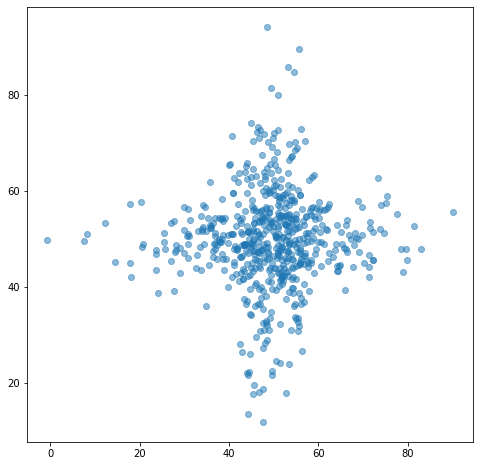

In [36]:
import matplotlib.pyplot as plt

k = 2
n = 300
N = n * k
means = [[50, 50], [50, 50]]
stds  = [[[200, 0],
          [0, 20]],
         [[20, 0],
          [00, 200]]]
data = []
for mean, std in zip(means, stds):
    data += [np.random.multivariate_normal(mean=mean, cov=std, size=n)]
data = np.concatenate(data)
# plotting
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=.5)

In [37]:
obj_k = KMeans(data, k=2)
obj_g = gmm(data, k=2)

/content/intro_to_phenomics/modules/gmm.py:37: RuntimeWarning: divide by zero encountered in log
  ll = np.log(0)


-inf
-4528.1815804491525
-4511.137748348599
-4475.180110063158
-4435.153160843353
-4412.034360508011
-4404.499210316469


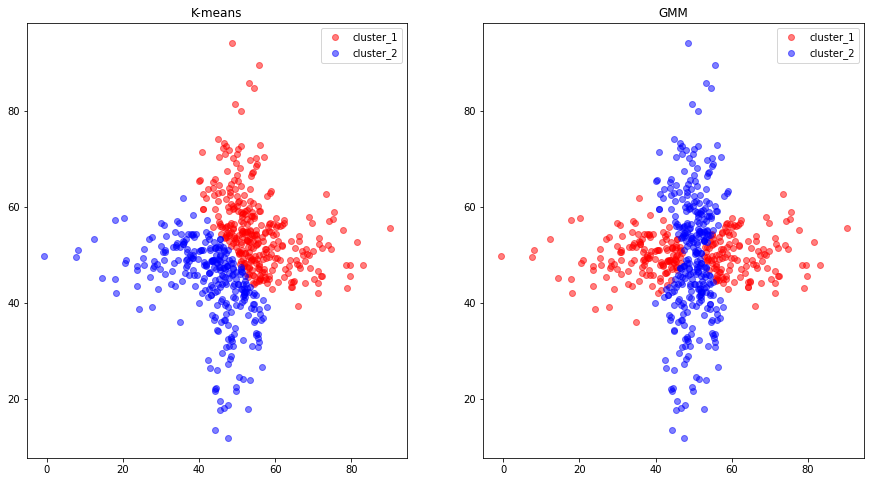

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].scatter(data[obj_k["labels"]==0, 0], data[obj_k["labels"]==0, 1], c="red", alpha=.5, label="cluster_1")
axes[0].scatter(data[obj_k["labels"]==1, 0], data[obj_k["labels"]==1, 1], c="blue", alpha=.5, label="cluster_2")
axes[0].set_title("K-means")
axes[0].legend()

axes[1].set_title("GMM")
axes[1].scatter(data[obj_g["labels"]==0, 0], data[obj_g["labels"]==0, 1], c="red", alpha=.5, label="cluster_1")
axes[1].scatter(data[obj_g["labels"]==1, 0], data[obj_g["labels"]==1, 1], c="blue", alpha=.5, label="cluster_2")
axes[1].legend()

In [40]:
obj_g["ll"]

-4402.82453055778

## **Work with a real image**

### Inspect the image

In [44]:
from modules.image_handler import load_img
img = load_img("data/plots.jpg")
h, w, c = img.shape
data = img.reshape((-1, c))
print("Shape: \n", img.shape)
print("Data: \n", data[:10])


Shape: 
 (128, 227, 3)
Data: 
 [[134 135  75]
 [150 152  89]
 [157 162  96]
 [169 174 107]
 [156 163  96]
 [136 142  78]
 [ 85  93  33]
 [ 46  53   1]
 [ 51  59  12]
 [ 60  67  25]]


### Cluster the image by GMM

In [45]:
from modules.gmm import gmm_sklearn
obj_g  = gmm_sklearn(data, k=3)
labels = obj_g["labels"]
centers = obj_g["centers"].astype(int)
# recover its shape to a 2D array
img_new = centers[labels].reshape((h, w, 3))

### Visualize the results

Text(0.5, 1.0, 'Clustered Image')

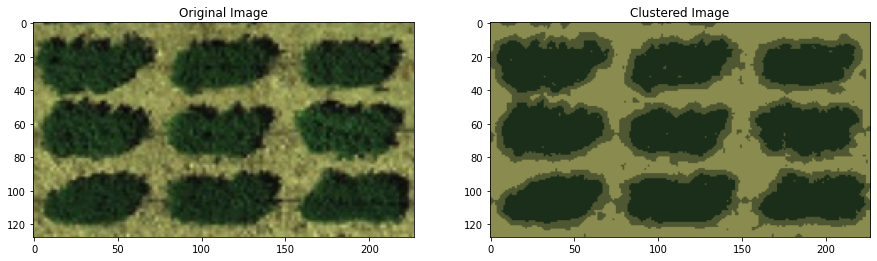

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[1].imshow(img_new)
axes[1].set_title("Clustered Image")

In [47]:
import pandas as pd
df = pd.DataFrame(img.reshape((-1, 3)))
df.columns = ["red", "green", "blue"]
print(df.iloc[:10])

   red  green  blue
0  134    135    75
1  150    152    89
2  157    162    96
3  169    174   107
4  156    163    96
5  136    142    78
6   85     93    33
7   46     53     1
8   51     59    12
9   60     67    25


In [48]:
import plotly
import plotly.express as px
import plotly.graph_objs as go

centers = obj_g["centers"]
labels  = obj_g["labels"]

colors     = ["rgb(%d, %d, %d)" % tuple(color.tolist()) for color in centers]
dfs        = df.iloc[::100]
labels_sub = labels[::100]
ls_points  = []
for i in range(3):
    ls_points += [go.Scatter3d(x=dfs.loc[labels_sub==i, "red"],
                               y=dfs.loc[labels_sub==i, "green"],
                               z=dfs.loc[labels_sub==i, "blue"],
                               mode='markers', name='cluster_%d' % (i + 1),
                               marker=dict(size=5, symbol='circle', opacity=0.7))]
# layout
layout = go.Layout(scene=dict(xaxis=dict(title="red"),
                              yaxis=dict(title="green"),
                              zaxis=dict(title="blue")),
                   margin=dict(l=100, r=200, b=0, t=0))
# show
fig = go.Figure(data=ls_points, layout=layout)
fig.show()
